In [3]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!pip install flow_vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# !git clone https://github.com/ultralytics/yolov5  # clone
# !cd yolov5
# %pip install -qr requirements.txt  # install

# from yolov5 import utils
# import mediapy as media
# import flow_vis
# display = utils.notebook_init()  # checks

In [5]:
import torch
import os
import glob
import numpy as np
import random

In [ ]:
# model = torch.hub.load('ultralytics/yolov5', 'yolov5x', device=0)

In [7]:
import torchvision

from torchvision.transforms.functional import crop

import cv2  
import numpy as np
import glob
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
import mediapy as media
from google.colab.patches import cv2_imshow

# from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
# from utils.torch_utils import select_device, time_sync
# from utils.plots import Annotator, colors, save_one_box
# from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
#                            increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)

In [ ]:
# half = False
# device = select_device(0)
# stride, names, pt = model.stride, model.names, model.pt

In [8]:
def flow_to_color(flow, hsv):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def getOpticalFlow(video, return_rgb_flow=True):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img,(224,224,1)))

    flows = []
    rgb_flows = []
    for i in range(0,len(video)-1):
        # calculate optical flow between each pair of frames


        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i+1], None, 0.5, 3, 15, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0],None,0,255,cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1],None,0,255,cv2.NORM_MINMAX)
        # Add into list 

        gss_app = cv2.GaussianBlur(flow,(5,5),1)

        if return_rgb_flow:
          flow_color = flow_vis.flow_to_color(gss_app, convert_to_bgr=False)
          rgb_flows.append(flow_color)

        flows.append(gss_app)
        
    # Padding the last frame as empty array
    flows.append(np.zeros((224,224,2)))

    flows = normalize(flows)
      
    return (np.array(flows, dtype=np.float32), np.array(rgb_flows))

### Optical Flow

Sliding windows to find most movimented area

In [ ]:
# def get_blurred_attention_area(rgb_frame, opt_frame, window_shape=(112,112), step_size=112):
#   """
#   rgb_frame: RGP Numpy Array (NxNx3)
#   opt_fram: Optical Flow Numpy Array (NxNx2)
#   """

#   window_shape = window_shape
#   step_size = step_size

#   best_x = -np.inf
#   best_y = -np.inf
#   best_sum = -np.inf
#   best_wind = -np.inf

#   for y in range(0, opt_frame.shape[0], step_size):
#     for x in range(0, opt_frame.shape[1], step_size):
#       window = opt_frame[y:y+window_shape[1], x:x+window_shape[0]]
#       rgb_window = rgb_frame[y:y+window_shape[1], x:x+window_shape[0]]

#       summ = window.sum()

#       if summ > best_sum:
#         best_sum = summ
#         best_x = x
#         best_y = y

#   start_point = (best_x, best_y) 
#   end_point = (best_x + window_shape[0], best_y + window_shape[1])
#   color = (255,255,255)
#   thickness = -1

#   blurred_img = cv2.GaussianBlur(rgb_frame, (21, 21), 0)
#   mask = np.zeros((rgb_frame.shape[0], rgb_frame.shape[1], 3), dtype=np.uint8)
#   mask = cv2.rectangle(mask, start_point, end_point, color, thickness)

#   best_cut = np.where(mask==np.array([255, 255, 255]), rgb_frame, blurred_img)

#   return best_cut, start_point, end_point

In [ ]:
# def get_attention_area(rgb_frame, opt_frame, window_shape=(112,112), step_size=112):
#   """
#   rgb_frame: RGP Numpy Array (NxNx3)
#   opt_fram: Optical Flow Numpy Array (NxNx2)
#   """

#   window_shape = window_shape
#   step_size = step_size

#   best_x = -np.inf
#   best_y = -np.inf
#   best_sum = -np.inf
#   best_wind = -np.inf

#   for y in range(0, opt_frame.shape[0], step_size):
#     for x in range(0, opt_frame.shape[1], step_size):
#       window = opt_frame[y:y+window_shape[1], x:x+window_shape[0]]
#       rgb_window = rgb_frame[y:y+window_shape[1], x:x+window_shape[0]]

#       summ = window.sum()

#       if summ > best_sum:
#         best_sum = summ
#         best_x = x
#         best_y = y

#   start_point = (best_x, best_y) 
#   end_point = (best_x + window_shape[0], best_y + window_shape[1])
#   best_cut = rgb_frame[best_y:best_y+window_shape[1], best_x:best_x+window_shape[0]]

#   return best_cut, start_point, end_point

In [9]:
import pandas as pd
from time import sleep

videos = pd.read_csv("/content/drive/MyDrive/ucf_experiments/experiment_2/data/train_for_network.txt", sep=' ', names=['path', 'label'])
videos_test = pd.read_csv("/content/drive/MyDrive/ucf_experiments/experiment_2/data/x_test_resized.csv")

In [10]:
videos_test = videos_test[['resized', 'label']].rename(columns={'resized': 'path'})

In [11]:
videos_test

,path,label
0,/content/drive/MyDrive/ucf_experiments/experim...,1
1,/content/drive/MyDrive/ucf_experiments/experim...,0
2,/content/drive/MyDrive/ucf_experiments/experim...,0
3,/content/drive/MyDrive/ucf_experiments/experim...,1
4,/content/drive/MyDrive/ucf_experiments/experim...,0
...,...,...
972,/content/drive/MyDrive/ucf_experiments/experim...,1
973,/content/drive/MyDrive/ucf_experiments/experim...,1
974,/content/drive/MyDrive/ucf_experiments/experim...,0
975,/content/drive/MyDrive/ucf_experiments/experim...,1


## Test Process Function

In [12]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean) / std

def dynamic_crop(opt_flows, rgb_frames, kernel=(21,21)):

    rgb_video = rgb_frames.copy()
    # sum of optical flow magnitude of individual frame
    magnitude = np.sum(opt_flows, axis=0)
    # filter slight noise by threshold 
    thresh = np.mean(magnitude)
    magnitude[magnitude<thresh] = 0
    # calculate center of gravity of magnitude map and adding 0.001 to avoid empty value
    x_pdf = np.sum(magnitude, axis=1) + 0.001
    y_pdf = np.sum(magnitude, axis=0) + 0.001
    # normalize PDF of x and y so that the sum of probs = 1
    x_pdf /= np.sum(x_pdf)
    y_pdf /= np.sum(y_pdf)

    x_pdf = x_pdf.sum(axis=1)
    y_pdf = y_pdf.sum(axis=1)

    # randomly choose some candidates for x and y 
    x_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=x_pdf)
    y_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=y_pdf)
    
    # get the mean of x and y coordinates for better robustness
    x = int(np.mean(x_points))
    y = int(np.mean(y_points))
    # avoid to beyond boundaries of array
    x = max(56,min(x,167))
    y = max(56,min(y,167))
    # get cropped video

    cropped = rgb_video[:,x-56:x+56,y-56:y+56,:].copy()

    w = 112
    h = 112

    start_point = (int(x-w/2), int(y-h/2))
    end_point = (int(x+w/2), int(y+h/2))
    color = (255,255,255)
    thickness = -1
    blurred_video = np.zeros_like(rgb_video)

    for idx, frame in enumerate(rgb_video):
      blurred_img = cv2.GaussianBlur(frame, kernel, 0)
      mask = np.zeros((frame.shape[0], frame.shape[1], 3), dtype=np.uint8)
      mask = cv2.rectangle(mask, start_point, end_point, color, thickness)

      best_cut = np.where(mask==np.array([255, 255, 255]), frame, blurred_img)
      blurred_video[idx] = best_cut

    return cropped, blurred_video

In [16]:
sample_url = videos_test.sample().path.squeeze()
sample_video = media.read_video(sample_url)

opt_frames, rgb_opt_frames = getOpticalFlow(sample_video, return_rgb_flow=True, )

In [23]:
rgb_cut, rgb_blur_23 = dynamic_crop(opt_frames, sample_video, kernel=(23, 23))
rgb_cut, rgb_blur_21 = dynamic_crop(opt_frames, sample_video, kernel=(21, 21))
rgb_cut, rgb_blur_15 = dynamic_crop(opt_frames, sample_video, kernel=(15, 15))
rgb_cut, rgb_blur_7 = dynamic_crop(opt_frames, sample_video, kernel=(7, 7))

In [24]:
media.show_videos([sample_video, rgb_blur_7, rgb_blur_15, rgb_blur_21, rgb_blur_23])

,,,,,,,,,

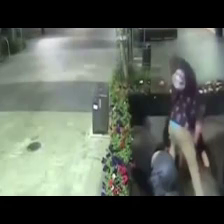
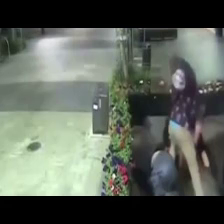
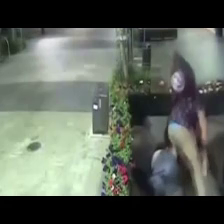
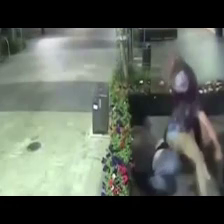
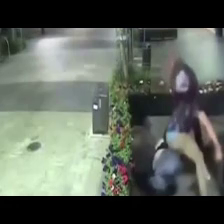
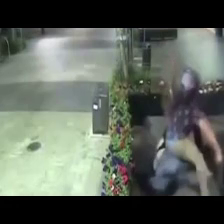
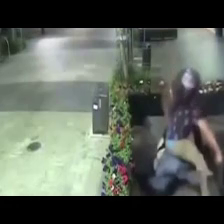
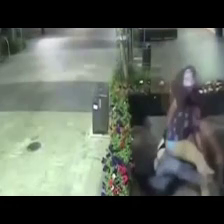
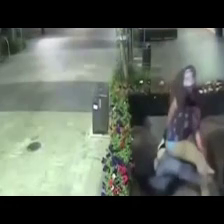
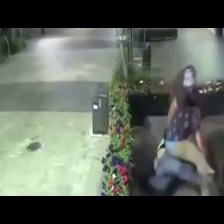

In [20]:
media.show_images(sample_video[:10])

,,,,,,,,,

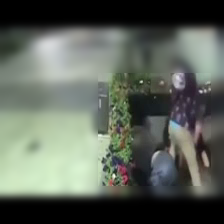
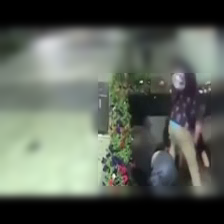
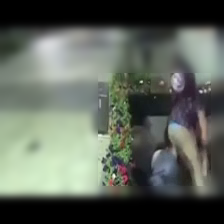
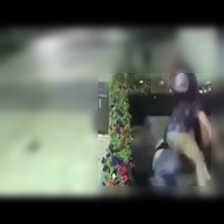
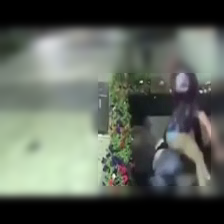
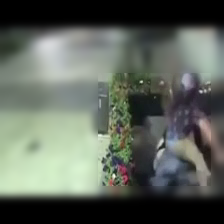
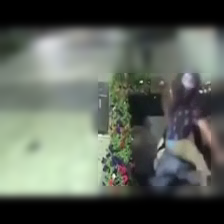
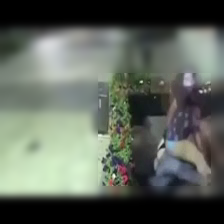
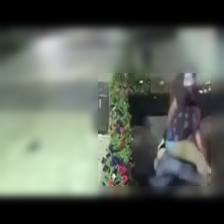
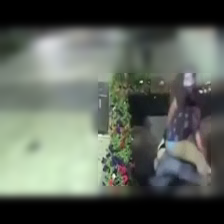

In [25]:
media.show_images(rgb_blur_23[:10])

,,,,,,,,,

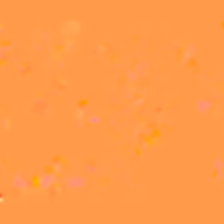
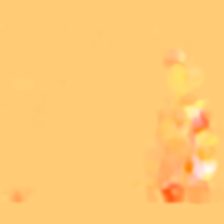
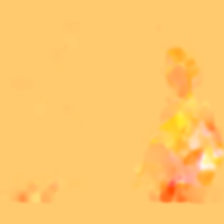
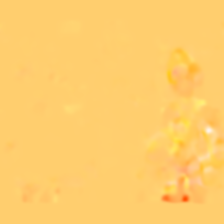
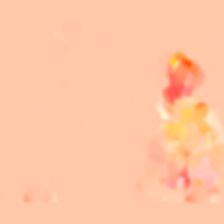
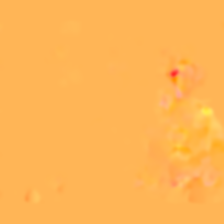
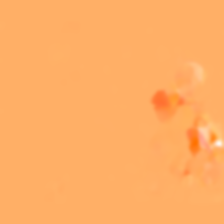
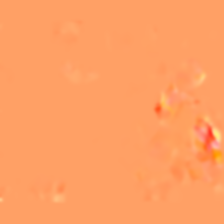
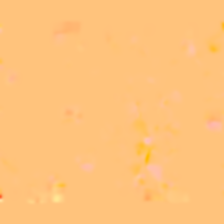
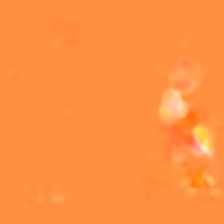

In [21]:
media.show_images(rgb_opt_frames[:10])

In [19]:
media.show_videos([sample_video, rgb_opt_frames, rgb_blur_21, rgb_cut])

In [33]:
media.show_videos([sample_video, rgb_opt_frames, rgb_blur_21, rgb_cut])

In [ ]:
video_ext_result = []

for rgb_frame in rgb_cut:
  pred = model(rgb_frame)
  detection_df  = pred.pandas().xyxy[0]
  has_person    = 'person' in detection_df.name.unique()
  if has_person:
    video_ext_result.append(rgb_frame[0])

NameError: ignored

In [ ]:
splitted = np.array_split(videos, 200)
splitted_test = np.array_split(videos_test, 10)

In [ ]:
def process_videos(videos_df, save_blur_base, save_crop_base, only_humans=True):
  videos = []

  for idx, row in videos_df.iterrows():
    video_path = row['path']
    label = row['label']

    rgb_frames = media.read_video(video_path)
    opt_frames, rgb_opt_frames = getOpticalFlow(rgb_frames, return_rgb_flow=False)
    result_crop_frames = []
    result_blur_frames = []


    rgb_cut, rgb_blur = dynamic_crop(opt_frames, rgb_frames)

    if only_humans: 
      for rgb_frame, rgb_blur_frame in zip(rgb_cut, rgb_blur):
        pred = model(rgb_frame)
        detection_df  = pred.pandas().xyxy[0]
        has_person    = 'person' in detection_df.name.unique()
        if has_person:
          result_crop_frames.append(rgb_frame)
          result_blur_frames.append(rgb_blur_frame)
    else:
      result_crop_frames = rgb_cut
      result_blur_frames = rgb_blur

    if len(result_crop_frames) < 1:
      continue

    video_blur_name = video_path.split('/')[-1].split('.')[0] + '_blur.mp4'
    video_crop_name = video_path.split('/')[-1].split('.')[0] + '_crop.mp4'

    video_blur_output_path = os.path.join(save_blur_base, video_blur_name)
    video_crop_output_path = os.path.join(save_crop_base, video_crop_name)

    media.write_video(video_blur_output_path, np.array(result_blur_frames))
    media.write_video(video_crop_output_path, np.array(result_crop_frames))

    row = {
      'crop_path': video_crop_output_path,
      'blur_path': video_blur_output_path,
      'label': label
    }

    videos.append((video_blur_output_path, video_crop_output_path, label))

  return videos

In [ ]:
import glob

glob.glob('/content/drive/MyDrive/ucf_experiments/experiment_3/data_checkpoints/train_nony_checkpoints/*_checkpoin.csv')[-1:]

['/content/drive/MyDrive/ucf_experiments/experiment_3/data_checkpoints/train_nony_checkpoints/199_checkpoin.csv']

In [ ]:
len(splitted)

200

## Train Data

In [ ]:
checkpoints = pd.DataFrame([])
start_idx = 155

for idx, split in tqdm(enumerate(splitted[start_idx:]), total=(len(splitted) - start_idx)):
  
  results = process_videos(
      split,
      save_blur_base='/content/drive/MyDrive/ucf_experiments/experiment_3/data_blur_non_yolo/train',
      save_crop_base='/content/drive/MyDrive/ucf_experiments/experiment_3/data_crop_non_yolo/train',
      only_humans=False
  )

  checkpoints = checkpoints.append(results, ignore_index=True)
  checkpoints.to_csv('/content/drive/MyDrive/ucf_experiments/experiment_3/data_checkpoints/train_nony_checkpoints/{}_checkpoin.csv'.format(str(start_idx + idx)))
  sleep(5)

100%|██████████| 45/45 [5:39:44<00:00, 452.99s/it]


## Test Data

In [ ]:
checkpoints = pd.DataFrame([])
start_idx = 3

for idx, split in tqdm(enumerate(splitted_test[start_idx:]), total=len(splitted_test) - start_idx):
  
  results = process_videos(
      split,
      save_blur_base='/content/drive/MyDrive/ucf_experiments/experiment_3/data_blur_non_yolo/test',
      save_crop_base='/content/drive/MyDrive/ucf_experiments/experiment_3/data_crop_non_yolo/test',
      only_humans=False
  )

  checkpoints = checkpoints.append(results, ignore_index=True)
  checkpoints.to_csv('/content/drive/MyDrive/ucf_experiments/experiment_3/data_checkpoints/test_nony_checkpoints/{}_checkpoin.csv'.format(str(start_idx + idx)))
  sleep(5)

100%|██████████| 7/7 [47:44<00:00, 409.22s/it]


In [ ]:
sample = videos.sample()
cuts = process_videos(sample)

original_video = media.read_video(sample.path.squeeze())
path, cut = cuts[0]

if len(cut) > 0:
  media.show_videos([original_video, cut])
else:
  print('No one detected')

In [ ]:
optical, rgb_optical = getOpticalFlow(original_video, return_rgb_flow=True)
media.show_videos([original_video, rgb_optical, cut])

In [ ]:
import glob

In [ ]:
parts = glob.glob('/content/drive/MyDrive/ucf_experiments/experiment_2/data/dynamic_blur/train/checkpoints/*_checkpoin.csv')

In [ ]:
test_parts = glob.glob('/content/drive/MyDrive/ucf_experiments/experiment_2/data/dynamic_blur/test/checkpoints/*_checkpoin.csv')

In [ ]:
dynamic_blur_train = pd.concat([ pd.read_csv(path) for path in parts ])

In [ ]:
dynamic_blur_test = pd.concat([ pd.read_csv(path) for path in test_parts ])

In [ ]:
len(videos)

19500

In [ ]:
dynamic_blur_train = dynamic_blur_train.drop_duplicates()
dynamic_blur_train = dynamic_blur_train.drop(columns=['Unnamed: 0'])

In [ ]:
dynamic_blur_test = dynamic_blur_test.drop_duplicates()
dynamic_blur_test = dynamic_blur_test.drop(columns=['Unnamed: 0'])

In [ ]:
dynamic_blur_test

In [ ]:
len(dynamic_blur_test)

938

In [ ]:
len(dynamic_blur_train)

18412

In [ ]:
dynamic_blur_train.to_csv('/content/drive/MyDrive/ucf_experiments/experiment_2/data/dynamic_blur/train/train.txt', header=None, index=False, sep=' ')

In [ ]:
dynamic_blur_test.to_csv('/content/drive/MyDrive/ucf_experiments/experiment_2/data/dynamic_crop_test/test.txt', header=None, index=False, sep=' ')